In [13]:
# Colab setup: install Prophet and cmdstan backend
!pip -q uninstall -y prophet fbprophet cmdstanpy pmdarima >/dev/null
!pip -q install cmdstanpy pmdarima==2.0.4 prophet >/dev/null

# Build / ensure the Stan backend once (takes ~2–4 min)
from cmdstanpy import install_cmdstan
cmdstan_path = install_cmdstan()
print("CmdStan installed at:", cmdstan_path)

DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


CmdStan install directory: /root/.cmdstan
CmdStan version 2.37.0 already installed
Test model compilation
CmdStan installed at: True


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet  # after install above
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

In [7]:
import os
os.environ['NUMPY_VERSION'] = '1.26.4'

In [3]:
!pip uninstall -y numpy >/dev/null
!pip install numpy==1.26.4 >/dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


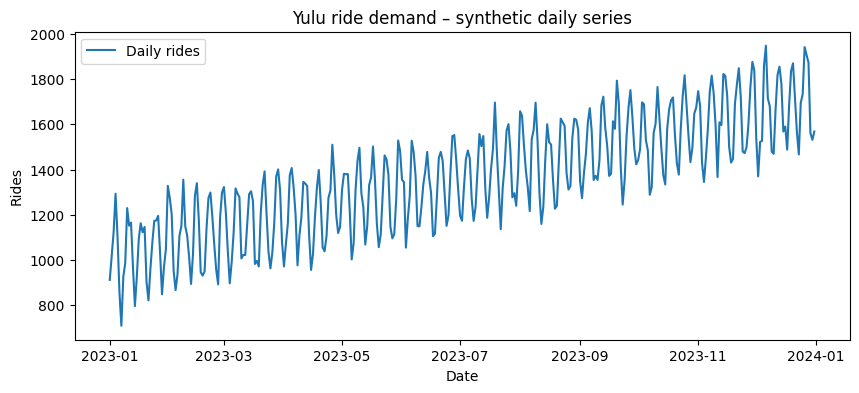

,date,rides
0,2023-01-01,912.408763
1,2023-01-02,1017.850793
2,2023-01-03,1123.289938
3,2023-01-04,1293.252942
4,2023-01-05,1106.727748


In [8]:
# Synthetic daily demand for 365 days
dates = pd.date_range("2023-01-01", periods=365, freq="D")

rides = (
    1000
    + np.arange(365) * 2.0                        # slow upward trend
    + 200 * np.sin(2 * np.pi * dates.dayofweek/7) # weekly seasonality
    + np.random.normal(0, 50, size=365)           # noise
)

df = pd.DataFrame({"date": dates, "rides": rides.astype(float)})

plt.figure(figsize=(10,4))
plt.plot(df["date"], df["rides"], label="Daily rides")
plt.title("Yulu ride demand – synthetic daily series")
plt.xlabel("Date"); plt.ylabel("Rides"); plt.legend(); plt.show()

df.head()


In [9]:
train = df.iloc[:-30].copy()
test  = df.iloc[-30:].copy()
len(train), len(test)


(335, 30)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA -> MAPE: 2.81% | RMSE: 62.40


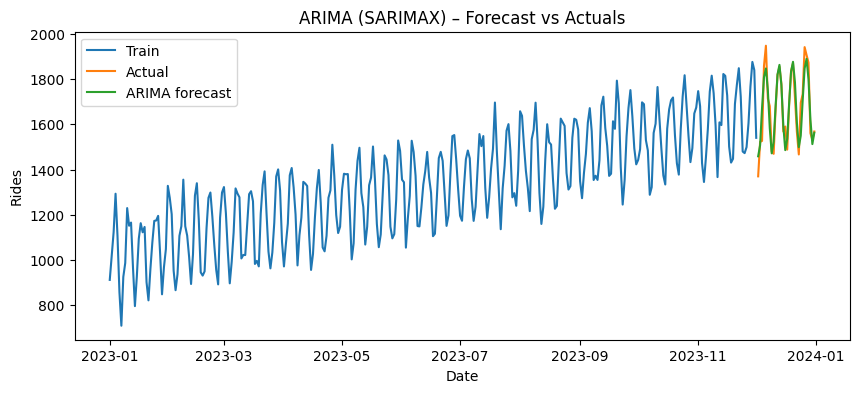

In [11]:
# A simple seasonal weekly SARIMAX; you can grid-search later if needed
arima = SARIMAX(
    train["rides"],
    order=(2,1,2),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast next 30 days
pred_arima = arima.predict(start=len(train), end=len(train)+len(test)-1)
mape_arima = mean_absolute_percentage_error(test["rides"], pred_arima) * 100
rmse_arima = mean_squared_error(test["rides"], pred_arima) # Removed squared=False
rmse_arima = np.sqrt(rmse_arima) # Calculate RMSE manually

print(f"ARIMA -> MAPE: {mape_arima:.2f}% | RMSE: {rmse_arima:.2f}")

plt.figure(figsize=(10,4))
plt.plot(train["date"], train["rides"], label="Train")
plt.plot(test["date"],  test["rides"],  label="Actual")
plt.plot(test["date"],  pred_arima,     label="ARIMA forecast")
plt.title("ARIMA (SARIMAX) – Forecast vs Actuals")
plt.xlabel("Date"); plt.ylabel("Rides"); plt.legend(); plt.show()

In [14]:
!pip list | grep prophet

prophet                                  1.2.1


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8smaqvn3/alcezone.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8smaqvn3/34tx3buu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27905', 'data', 'file=/tmp/tmp8smaqvn3/alcezone.json', 'init=/tmp/tmp8smaqvn3/34tx3buu.json', 'output', 'file=/tmp/tmp8smaqvn3/prophet_modela153cw6r/prophet_model-20251104110912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:09:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:09:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet -> MAPE: 2.82% | RMSE: 62.18


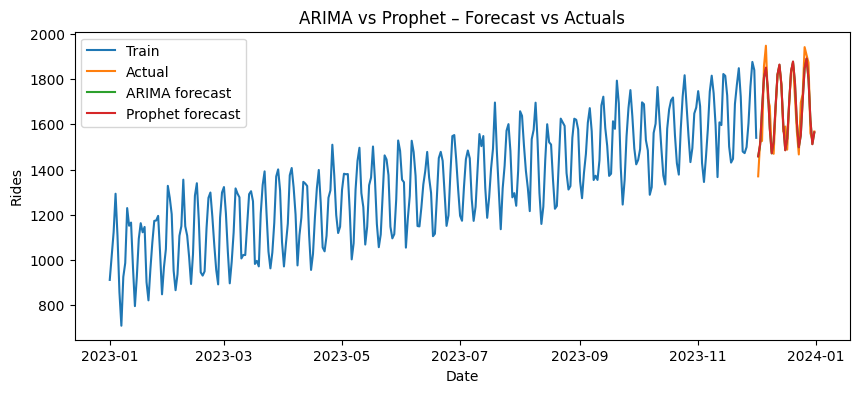

In [16]:
# Prophet requires a specific dataframe format
train_prophet = train.rename(columns={'date': 'ds', 'rides': 'y'})

# Initialize and fit the model
prophet = Prophet()
prophet.fit(train_prophet)

# Create a dataframe for future dates
future = prophet.make_future_dataframe(periods=len(test), include_history=False)

# Forecast
forecast = prophet.predict(future)
pred_prophet = forecast['yhat']

# Evaluate Prophet model
mape_prophet = mean_absolute_percentage_error(test["rides"], pred_prophet) * 100
rmse_prophet = np.sqrt(mean_squared_error(test["rides"], pred_prophet))

print(f"Prophet -> MAPE: {mape_prophet:.2f}% | RMSE: {rmse_prophet:.2f}")

plt.figure(figsize=(10,4))
plt.plot(train["date"], train["rides"], label="Train")
plt.plot(test["date"],  test["rides"],  label="Actual")
plt.plot(test["date"],  pred_arima,     label="ARIMA forecast")
plt.plot(test["date"],  pred_prophet,   label="Prophet forecast")
plt.title("ARIMA vs Prophet – Forecast vs Actuals")
plt.xlabel("Date"); plt.ylabel("Rides"); plt.legend(); plt.show()

In [18]:
print("---- Model comparison ----")
print(f"ARIMA   MAPE: {mape_arima:.2f}% | RMSE: {rmse_arima:.2f}")
print(f"Prophet MAPE: {mape_prophet:.2f}% | RMSE: {rmse_prophet:.2f}")

better = "Prophet" if mape_prophet < mape_arima else "ARIMA"
print(f"Better by MAPE: {better}")

---- Model comparison ----
ARIMA   MAPE: 2.81% | RMSE: 62.40
Prophet MAPE: 2.82% | RMSE: 62.18
Better by MAPE: ARIMA


In [20]:
out = pd.DataFrame({
    "date": test["date"].values,
    "actual": test["rides"].values,
    "arima_forecast": pred_arima.values,
    "prophet_forecast": pred_prophet.values
})
out.to_csv("yulu_forecasts_comparison.csv", index=False)
out.head()

,date,actual,arima_forecast,prophet_forecast
0,2023-12-02,1370.050500,1458.706957,1458.365061
1,2023-12-03,1522.333428,1507.697733,1511.073375
2,2023-12-04,1526.739033,1671.425060,1666.815892
3,2023-12-05,1857.618545,1808.233112,1806.820796
4,2023-12-06,1947.392796,1846.767366,1850.781808
